In [13]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted
from glob import glob

from PIL import Image
import skvideo.io

import matplotlib.pyplot as plt

print(skvideo._FFMPEG_SUPPORTED_ENCODERS)

[b'., A64', b'.264', b'.265', b'.302', b'.3g2', b'.3gp', b'.722', b'.a64', b'.aa3', b'.aac', b'.ac3', b'.adts', b'.adx', b'.afc', b'.aif', b'.aifc', b'.aiff', b'.al', b'.amr', b'.apng', b'.asf', b'.ass', b'.ast', b'.au', b'.avc', b'.avi', b'.bit', b'.bmp', b'.caf', b'.cavs', b'.chk', b'.cif', b'.daud', b'.dif', b'.dnxhd', b'.dpx', b'.drc', b'.dts', b'.dv', b'.dvd', b'.eac3', b'.f4v', b'.ffm', b'.ffmeta', b'.flac', b'.flm', b'.flv', b'.g722', b'.g723_1', b'.gif', b'.gxf', b'.h261', b'.h263', b'.h264', b'.h265', b'.h26l', b'.hevc', b'.ico', b'.im1', b'.im24', b'.im8', b'.ircam', b'.isma', b'.ismv', b'.ivf', b'.j2c', b'.j2k', b'.jls', b'.jp2', b'.jpeg', b'.jpg', b'.js', b'.jss', b'.latm', b'.lbc', b'.ljpg', b'.loas', b'.lrc', b'.m1v', b'.m2a', b'.m2t', b'.m2ts', b'.m2v', b'.m3u8', b'.m4a', b'.m4v', b'.mj2', b'.mjpeg', b'.mjpg', b'.mk3d', b'.mka', b'.mks', b'.mkv', b'.mlp', b'.mmf', b'.mov', b'.mp2', b'.mp3', b'.mp4', b'.mpa', b'.mpeg', b'.mpg', b'.mpo', b'.mts', b'.mxf', b'.nut', b'.oga',

In [14]:
img_dims = (512, 512, 3)

class VideoDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, data_folder="data", task="train", split=0.8, video_len=24, img_dims=img_dims, batch_size=1, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.video_len = video_len
        self.dims = img_dims
        self.task = task
        self.data_directory = data_folder
        self.image_videos_files = natsorted(glob(self.data_directory+"/cloud*"))
        if self.task != "test":
            self.segmentation_videos_files = natsorted(glob(self.data_directory+"/clear*"))
            self.img_list = list(zip(self.image_videos_files, self.segmentation_videos_files))
        else:
            self.img_list = [[f] for f in self.image_videos_files]
        self.nb = len(self.img_list) * self.video_len
        self.split = int(split * self.nb)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        if self.task == "train":
            return int(self.split / self.batch_size)
        elif self.task == "val":
            return int((self.nb - self.split) / self.batch_size)
        elif self.task == "test":
            return self.nb

    def __getitem__(self, idx):
        # Generate indexes of the batch
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.nb * self.video_len)
        if self.task == "train":
            self.indexes = self.indexes[:self.split]
        elif self.task == "val":
            self.indexes = self.indexes[self.split:]
        if self.task != "test" and self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        # Initialization
        X = np.empty((self.batch_size, *self.dims), dtype=np.float32)
        if self.task != "test":
            Y = np.empty((self.batch_size, *self.dims), dtype=np.float32)

        # Generate data
        for i, idx in enumerate(indexes):
            # Reading The iceberg video
            cloud_video = cv2.VideoCapture(self.img_list[idx // self.video_len][0])
            if self.task != "test":
                clear_video = cv2.VideoCapture(self.img_list[idx // self.video_len][1])
            n = idx % self.video_len
            cloud_video.set(1, n)
            ret, cloud = cloud_video.read()
            cloud = cv2.cvtColor(cloud, cv2.COLOR_BGR2RGB)
            cloud = cv2.resize(cloud, img_dims[:2])
            X[i,] = np.squeeze(cloud) / 255.

            # Reading the segmentation video
            if self.task != "test":
                clear_video.set(1, n)
                ret, clear = clear_video.read()
                clear = cv2.cvtColor(clear, cv2.COLOR_BGR2RGB)
                clear = cv2.resize(clear, img_dims[:2])
                Y[i,] = np.squeeze(clear) / 255.

        if self.task != "test":
            return X, Y
        else:
            return X

In [15]:
split = 0.8
train_gen = VideoDataGenerator(task="train", split=split)
val_gen = VideoDataGenerator(task="val", split=split)

(512, 512, 3)


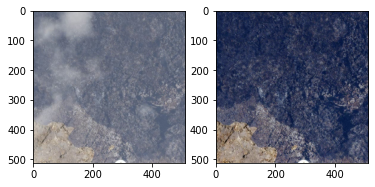

In [16]:
batch = 18
idx = 0

print(train_gen[batch][0][idx].shape)

img = train_gen[batch][0][idx]
seg = train_gen[batch][1][idx]

fig, axes = plt.subplots(1,2)
axes[0].imshow(img)
axes[1].imshow(seg)
plt.show()

In [18]:
tf.keras.backend.clear_session()

inputs = Input(shape=img_dims)

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D (512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (UpSampling2D (size = (2,2)) (drop5)) # Convolution after upsampling, Equivalent to transpose convolution operation!
merge6 = concatenate([drop4,up6],axis=3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7],axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9],axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D (3, 1, activation = 'sigmoid') (conv9) #I suspect that this sigmoid activation function is superfluous, because binary cross-entropy is used in the subsequent loss, including sigmoid

model = Model(inputs=[inputs], outputs=[conv10])
model.compile (optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy']) #The model must be compiled before execution https://keras-cn.readthedocs.io/en/ latest / getting_started / sequential_model /
#Using binary cross entropy, that is, sigmoid cross entropy, metrics generally use the accuracy rate, it will make the accuracy rate develop higher
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
#save best model if model improved
model_name = "clouds.h5"
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=2, verbose=1, callbacks=[best_checkpoint])

In [20]:
model = load_model(model_name)

C:\Users\Rock_\AppData\Local\Temp/ipykernel_8472/3711873814.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Rock_\AppData\Local\Temp/ipykernel_8472/3711873814.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 3)


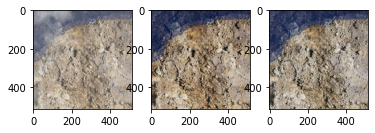

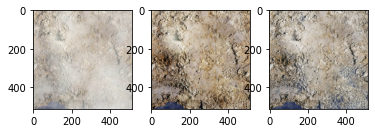

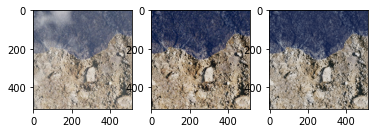

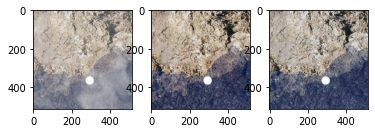

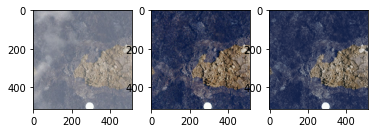

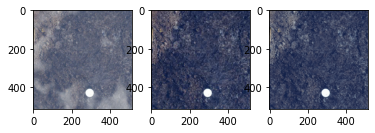

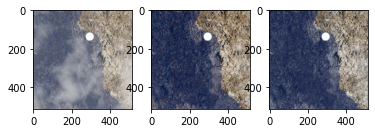

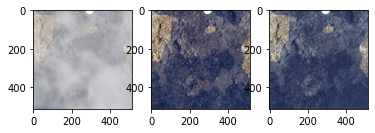

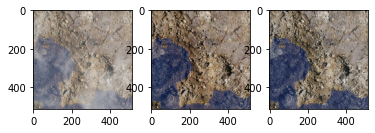

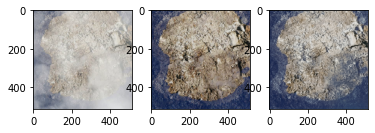

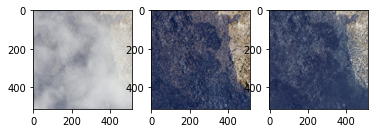

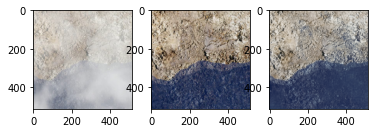

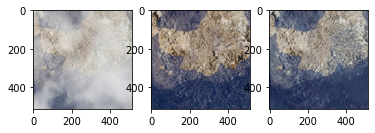

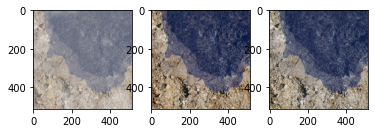

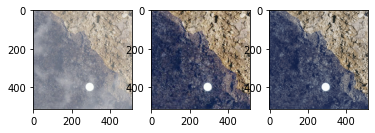

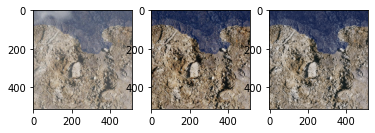

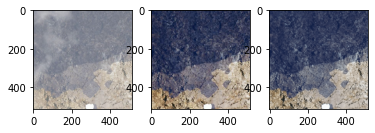

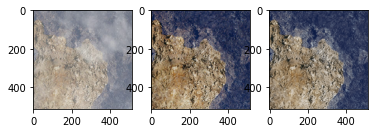

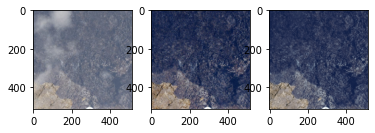

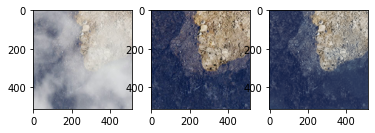

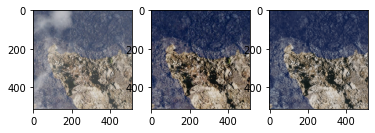

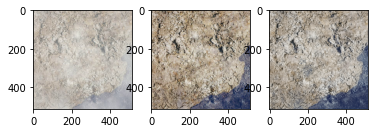

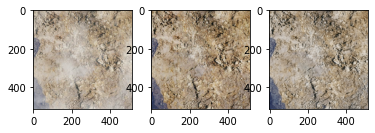

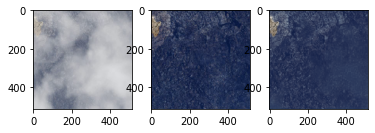

In [21]:
for batch in range(24):

    for img, seg in zip(train_gen[batch][0], train_gen[batch][1]):

        pred = np.squeeze(model.predict(np.expand_dims(img, axis=0))) * 255
        
        #print(pred.shape)
        #pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
        pred_img = Image.fromarray(pred.astype(np.uint8))
        
        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(img)
        axes[1].imshow(np.squeeze(seg))
        axes[2].imshow(pred_img)
        fig.show()